In [1]:
import torch
import numpy as np
import opacus
from torch import nn
from opacus import PrivacyEngine
from opacus.accountants import RDPAccountant
from opacus.accountants.analysis import rdp as analysis
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import os
path_project = os.path.dirname(os.path.abspath('.'))
import sys
sys.path.append(os.path.join(path_project, 'src'))
sys.path.append(os.path.join(path_project, 'exp/script'))
import noise_utils

import warnings
import math

warnings.simplefilter(action="ignore", category=UserWarning)
img_path = os.path.join(path_project, 'exp', 'img')

This notebook can visualize the group-privacy conversion with normal DP and RDP.

## Plot group-privacy epsilon with group_k s

Since we need to calculate the RDP, we use Gaussian mechanism.

- Normal DP
Gaussian mechanism => RDP => Normal DP => Normal group-DP

- RDP
Gaussian mechanism => RDP => group-RDP => Normal group-DP

In [5]:
from noise_utils import get_normal_group_privacy_spent, get_group_privacy_spent

def generate_both_dp(sigma: float, T: int, group_k: float, final_delta: float, data_size=100):
    accountant = RDPAccountant()
    for _ in range(T*data_size):
        accountant.step(noise_multiplier=sigma, sample_rate=1.0/data_size)
    print(accountant.history)
    rdp_eps, alpha = get_group_privacy_spent(group_k=group_k, accountant_history=accountant.history, delta=final_delta)
    normal_eps, normal_delta = get_normal_group_privacy_spent(group_k=group_k, accountant_history=accountant.history, delta=final_delta)
    return rdp_eps, normal_eps

def generate_group_rdp(sigma: float, T: int, group_k: float, final_delta: float, data_size=100):
    accountant = RDPAccountant()
    for _ in range(T*data_size):
        accountant.step(noise_multiplier=sigma, sample_rate=1.0/data_size)
    rdp_eps, alpha = get_group_privacy_spent(group_k=group_k, accountant_history=accountant.history, delta=final_delta)
    return rdp_eps

def generate_group_normaldp(sigma: float, T: int, group_k: float, final_delta: float, data_size=100):
    accountant = RDPAccountant()
    for _ in range(T*data_size):
        accountant.step(noise_multiplier=sigma, sample_rate=1.0/data_size)
    normal_eps, normal_delta = get_normal_group_privacy_spent(group_k=group_k, accountant_history=accountant.history, delta=final_delta)
    return normal_eps

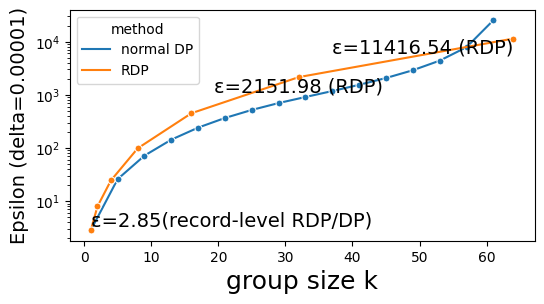

In [26]:
group_k_list = [1, 2, 4, 8, 16, 32, 64]
group_k_normal_dp_list = range(1, 64, 4)
final_delta = 0.00001
sigma = 5.0

# for sigma in [1.0, 2.0, 5.0, 10.0]:
for T in [1000]:
    data = {'k': [], 'epsilon': [], 'method': []}

    for group_k in group_k_normal_dp_list:
        normal_dp = generate_group_normaldp(sigma=sigma, T=T, group_k=group_k, final_delta=final_delta, data_size=100)

        data['k'].append(group_k)
        data['epsilon'].append(normal_dp)
        data['method'].append('normal DP')

    for group_k in group_k_list:
        rdp_group_dp = generate_group_rdp(sigma=sigma, T=T, group_k=group_k, final_delta=final_delta, data_size=100)

        data['k'].append(group_k)
        data['epsilon'].append(rdp_group_dp)
        data['method'].append('RDP')
    

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    sns.lineplot(x='k', y='epsilon', data=data, hue='method', ax=ax, marker='o', markersize=5)
    ax.set_xlabel('group size k', fontsize=18)
    ax.set_ylabel('Epsilon (delta=0.00001)', fontsize=14)
    # ax.set_title(f'#round={T}')
    # ax.set_xscale('log')
    ax.set_yscale('log')
    plt.text(data['k'][0], data['epsilon'][0], f'ε={data["epsilon"][0]:.2f}(record-level RDP/DP)', 
            verticalalignment='bottom', horizontalalignment='left', fontsize=14)
    plt.text(data['k'][-2], data['epsilon'][-2], f'ε={data["epsilon"][-2]:.2f} (RDP)', 
            verticalalignment='top', horizontalalignment='center', fontsize=14)
    plt.text(data['k'][-1], data['epsilon'][-1], f'ε={data["epsilon"][-1]:.2f} (RDP)', 
            verticalalignment='top', horizontalalignment='right', fontsize=14)
    # plt.text(data['k'][-1], data['epsilon'][-1], f'ε={data["epsilon"][-1]:.2f} (normal DP)', 
    #      verticalalignment='top', horizontalalignment='right', fontsize=14)
    fig.savefig(
        os.path.join(img_path, "groupdp_comparison_sigma5.png"),
        dpi=150,
        bbox_inches="tight",
    )
